In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_30.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'

/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Only extract hidden states
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states.append(outputs.hidden_states[20].mean(dim=1).cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 232/232 [01:03<00:00,  3.68it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 243/243 [01:20<00:00,  3.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training MLP model with input_dim=4096 and hidden_dim=256


Training Epochs:   1%|          | 12/2000 [00:00<01:04, 30.60it/s]

Epoch 10/2000, Loss: 0.4586
Test Accuracy at Epoch 10: 67.11%
Test F1-score at Epoch 10: 0.6988
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.63      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380

New best model saved with F1-score 0.6988 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.73      0.57      0.64       194
non_infringement       0.63      0.78      0.70       186

        accuracy                           0.67       380
       macro avg       0.68      0.67      0.67       380
    weighted avg       0.68      0.67      0.67       380



Training Epochs:   1%|▏         | 25/2000 [00:00<01:00, 32.83it/s]

Epoch 20/2000, Loss: 0.3533
Test Accuracy at Epoch 20: 75.00%
Test F1-score at Epoch 20: 0.7654
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380

New best model saved with F1-score 0.7654 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.81      0.67      0.73       194
non_infringement       0.71      0.83      0.77       186

        accuracy                           0.75       380
       macro avg       0.76      0.75      0.75       380
    weighted avg       0.76      0.75      0.75       380



Training Epochs:   2%|▏         | 37/2000 [00:01<00:58, 33.82it/s]

Epoch 30/2000, Loss: 0.3056
Test Accuracy at Epoch 30: 73.95%
Test F1-score at Epoch 30: 0.7519
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.78      0.68      0.73       194
non_infringement       0.70      0.81      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:   2%|▏         | 45/2000 [00:01<01:05, 29.68it/s]

Epoch 40/2000, Loss: 0.2606
Test Accuracy at Epoch 40: 72.11%
Test F1-score at Epoch 40: 0.7282
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.70      0.76      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:   3%|▎         | 53/2000 [00:01<01:06, 29.28it/s]

Epoch 50/2000, Loss: 0.2212
Test Accuracy at Epoch 50: 75.79%
Test F1-score at Epoch 50: 0.7444
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.75      0.79      0.77       194
non_infringement       0.77      0.72      0.74       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   3%|▎         | 61/2000 [00:02<01:12, 26.90it/s]

Epoch 60/2000, Loss: 0.1918
Test Accuracy at Epoch 60: 73.68%
Test F1-score at Epoch 60: 0.7436
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   4%|▎         | 72/2000 [00:02<01:05, 29.31it/s]

Epoch 70/2000, Loss: 0.1619
Test Accuracy at Epoch 70: 77.37%
Test F1-score at Epoch 70: 0.7650
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.77      0.79      0.78       194
non_infringement       0.78      0.75      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:   4%|▍         | 85/2000 [00:02<00:59, 32.05it/s]

Epoch 80/2000, Loss: 0.1577
Test Accuracy at Epoch 80: 72.89%
Test F1-score at Epoch 80: 0.7469
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.79      0.64      0.71       194
non_infringement       0.69      0.82      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   5%|▍         | 93/2000 [00:03<00:59, 31.96it/s]

Epoch 90/2000, Loss: 0.1399
Test Accuracy at Epoch 90: 73.16%
Test F1-score at Epoch 90: 0.7463
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.78      0.66      0.72       194
non_infringement       0.69      0.81      0.75       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   5%|▌         | 102/2000 [00:03<01:01, 31.01it/s]

Epoch 100/2000, Loss: 0.1309
Test Accuracy at Epoch 100: 76.84%
Test F1-score at Epoch 100: 0.7596
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.77      0.79      0.78       194
non_infringement       0.77      0.75      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:   6%|▌         | 115/2000 [00:03<00:59, 31.51it/s]

Epoch 110/2000, Loss: 0.1309
Test Accuracy at Epoch 110: 77.89%
Test F1-score at Epoch 110: 0.7742
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.77      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380

New best model saved with F1-score 0.7742 at epoch 110
Best Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.77      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:   6%|▋         | 125/2000 [00:04<00:50, 36.98it/s]

Epoch 120/2000, Loss: 0.1224
Test Accuracy at Epoch 120: 73.95%
Test F1-score at Epoch 120: 0.7455
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   7%|▋         | 134/2000 [00:04<00:51, 35.98it/s]

Epoch 130/2000, Loss: 0.1206
Test Accuracy at Epoch 130: 73.42%
Test F1-score at Epoch 130: 0.7417
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:   7%|▋         | 144/2000 [00:04<00:54, 34.34it/s]

Epoch 140/2000, Loss: 0.1182
Test Accuracy at Epoch 140: 73.68%
Test F1-score at Epoch 140: 0.7436
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   8%|▊         | 154/2000 [00:04<00:47, 39.00it/s]

Epoch 150/2000, Loss: 0.1136
Test Accuracy at Epoch 150: 76.05%
Test F1-score at Epoch 150: 0.7573
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.77      0.76      0.76       194
non_infringement       0.75      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   8%|▊         | 164/2000 [00:05<00:49, 37.32it/s]

Epoch 160/2000, Loss: 0.1190
Test Accuracy at Epoch 160: 73.95%
Test F1-score at Epoch 160: 0.7455
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.77      0.70      0.73       194
non_infringement       0.71      0.78      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:   9%|▊         | 174/2000 [00:05<00:53, 34.12it/s]

Epoch 170/2000, Loss: 0.1104
Test Accuracy at Epoch 170: 76.05%
Test F1-score at Epoch 170: 0.7573
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.77      0.76      0.76       194
non_infringement       0.75      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:   9%|▉         | 184/2000 [00:05<00:47, 37.97it/s]

Epoch 180/2000, Loss: 0.1114
Test Accuracy at Epoch 180: 76.32%
Test F1-score at Epoch 180: 0.7581
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  10%|▉         | 198/2000 [00:06<00:45, 39.99it/s]

Epoch 190/2000, Loss: 0.1097
Test Accuracy at Epoch 190: 78.16%
Test F1-score at Epoch 190: 0.7726
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.78      0.80      0.79       194
non_infringement       0.79      0.76      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  10%|█         | 203/2000 [00:06<00:48, 36.84it/s]

Epoch 200/2000, Loss: 0.1047
Test Accuracy at Epoch 200: 77.63%
Test F1-score at Epoch 200: 0.7684
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.77      0.79      0.78       194
non_infringement       0.78      0.76      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



Training Epochs:  11%|█         | 213/2000 [00:06<00:45, 39.30it/s]

Epoch 210/2000, Loss: 0.1045
Test Accuracy at Epoch 210: 72.63%
Test F1-score at Epoch 210: 0.7320
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.75      0.69      0.72       194
non_infringement       0.70      0.76      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  11%|█▏        | 228/2000 [00:06<00:43, 40.80it/s]

Epoch 220/2000, Loss: 0.1025
Test Accuracy at Epoch 220: 75.53%
Test F1-score at Epoch 220: 0.7520
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.75      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  12%|█▏        | 233/2000 [00:06<00:47, 37.23it/s]

Epoch 230/2000, Loss: 0.1054
Test Accuracy at Epoch 230: 74.74%
Test F1-score at Epoch 230: 0.7460
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  12%|█▏        | 243/2000 [00:07<00:44, 39.74it/s]

Epoch 240/2000, Loss: 0.1025
Test Accuracy at Epoch 240: 74.47%
Test F1-score at Epoch 240: 0.7441
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  13%|█▎        | 257/2000 [00:07<00:43, 40.44it/s]

Epoch 250/2000, Loss: 0.1009
Test Accuracy at Epoch 250: 73.16%
Test F1-score at Epoch 250: 0.7344
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.71      0.76      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  13%|█▎        | 262/2000 [00:07<00:47, 36.86it/s]

Epoch 260/2000, Loss: 0.1005
Test Accuracy at Epoch 260: 73.95%
Test F1-score at Epoch 260: 0.7402
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  14%|█▍        | 275/2000 [00:08<00:43, 39.48it/s]

Epoch 270/2000, Loss: 0.0997
Test Accuracy at Epoch 270: 74.21%
Test F1-score at Epoch 270: 0.7421
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  14%|█▍        | 285/2000 [00:08<00:45, 38.05it/s]

Epoch 280/2000, Loss: 0.0992
Test Accuracy at Epoch 280: 74.21%
Test F1-score at Epoch 280: 0.7421
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  15%|█▍        | 295/2000 [00:08<00:46, 37.01it/s]

Epoch 290/2000, Loss: 0.1010
Test Accuracy at Epoch 290: 77.11%
Test F1-score at Epoch 290: 0.7603
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.76      0.80      0.78       194
non_infringement       0.78      0.74      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  15%|█▌        | 305/2000 [00:08<00:41, 41.19it/s]

Epoch 300/2000, Loss: 0.1015
Test Accuracy at Epoch 300: 71.58%
Test F1-score at Epoch 300: 0.7231
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.74      0.68      0.71       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  16%|█▌        | 315/2000 [00:09<00:42, 39.20it/s]

Epoch 310/2000, Loss: 0.1023
Test Accuracy at Epoch 310: 74.21%
Test F1-score at Epoch 310: 0.7421
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  16%|█▋        | 325/2000 [00:09<00:48, 34.88it/s]

Epoch 320/2000, Loss: 0.0992
Test Accuracy at Epoch 320: 74.47%
Test F1-score at Epoch 320: 0.7441
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.75       194
non_infringement       0.73      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  17%|█▋        | 335/2000 [00:09<00:44, 37.70it/s]

Epoch 330/2000, Loss: 0.0978
Test Accuracy at Epoch 330: 76.58%
Test F1-score at Epoch 330: 0.7601
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  17%|█▋        | 348/2000 [00:09<00:42, 38.87it/s]

Epoch 340/2000, Loss: 0.0977
Test Accuracy at Epoch 340: 73.42%
Test F1-score at Epoch 340: 0.7363
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  18%|█▊        | 352/2000 [00:10<00:54, 30.29it/s]

Epoch 350/2000, Loss: 0.0976
Test Accuracy at Epoch 350: 73.42%
Test F1-score at Epoch 350: 0.7363
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  18%|█▊        | 367/2000 [00:10<00:53, 30.69it/s]

Epoch 360/2000, Loss: 0.1001
Test Accuracy at Epoch 360: 76.05%
Test F1-score at Epoch 360: 0.7507
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.76      0.78      0.77       194
non_infringement       0.77      0.74      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  19%|█▊        | 371/2000 [00:10<00:57, 28.34it/s]

Epoch 370/2000, Loss: 0.1031
Test Accuracy at Epoch 370: 71.05%
Test F1-score at Epoch 370: 0.7236
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.75      0.65      0.70       194
non_infringement       0.68      0.77      0.72       186

        accuracy                           0.71       380
       macro avg       0.71      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  19%|█▉        | 385/2000 [00:11<00:43, 37.07it/s]

Epoch 380/2000, Loss: 0.0985
Test Accuracy at Epoch 380: 73.42%
Test F1-score at Epoch 380: 0.7363
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.75      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  20%|█▉        | 398/2000 [00:11<00:42, 37.65it/s]

Epoch 390/2000, Loss: 0.1004
Test Accuracy at Epoch 390: 74.74%
Test F1-score at Epoch 390: 0.7460
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  20%|██        | 402/2000 [00:11<00:46, 34.45it/s]

Epoch 400/2000, Loss: 0.0973
Test Accuracy at Epoch 400: 74.74%
Test F1-score at Epoch 400: 0.7460
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  21%|██        | 411/2000 [00:11<00:42, 37.07it/s]

Epoch 410/2000, Loss: 0.0961
Test Accuracy at Epoch 410: 74.47%
Test F1-score at Epoch 410: 0.7427
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.75      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  21%|██▏       | 425/2000 [00:12<00:41, 38.02it/s]

Epoch 420/2000, Loss: 0.0959
Test Accuracy at Epoch 420: 73.68%
Test F1-score at Epoch 420: 0.7368
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.75      0.72      0.74       194
non_infringement       0.72      0.75      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  22%|██▏       | 435/2000 [00:12<00:43, 35.64it/s]

Epoch 430/2000, Loss: 0.0956
Test Accuracy at Epoch 430: 73.95%
Test F1-score at Epoch 430: 0.7402
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  22%|██▏       | 444/2000 [00:12<00:45, 34.05it/s]

Epoch 440/2000, Loss: 0.0964
Test Accuracy at Epoch 440: 71.84%
Test F1-score at Epoch 440: 0.7249
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.75      0.68      0.71       194
non_infringement       0.69      0.76      0.72       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  23%|██▎       | 453/2000 [00:13<00:42, 36.51it/s]

Epoch 450/2000, Loss: 0.0982
Test Accuracy at Epoch 450: 76.05%
Test F1-score at Epoch 450: 0.7507
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.76      0.78      0.77       194
non_infringement       0.77      0.74      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  23%|██▎       | 462/2000 [00:13<00:43, 35.24it/s]

Epoch 460/2000, Loss: 0.0961
Test Accuracy at Epoch 460: 76.84%
Test F1-score at Epoch 460: 0.7622
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.77      0.78      0.77       194
non_infringement       0.77      0.76      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  24%|██▍       | 475/2000 [00:13<00:45, 33.23it/s]

Epoch 470/2000, Loss: 0.0953
Test Accuracy at Epoch 470: 74.74%
Test F1-score at Epoch 470: 0.7447
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.74      0.75      0.74       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  24%|██▍       | 484/2000 [00:14<00:46, 32.61it/s]

Epoch 480/2000, Loss: 0.0953
Test Accuracy at Epoch 480: 76.58%
Test F1-score at Epoch 480: 0.7601
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  25%|██▍       | 498/2000 [00:14<00:38, 39.24it/s]

Epoch 490/2000, Loss: 0.0951
Test Accuracy at Epoch 490: 74.74%
Test F1-score at Epoch 490: 0.7460
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  25%|██▌       | 509/2000 [00:14<00:36, 40.38it/s]

Epoch 500/2000, Loss: 0.0948
Test Accuracy at Epoch 500: 74.74%
Test F1-score at Epoch 500: 0.7460
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  26%|██▌       | 514/2000 [00:14<00:41, 35.65it/s]

Epoch 510/2000, Loss: 0.0947
Test Accuracy at Epoch 510: 73.95%
Test F1-score at Epoch 510: 0.7402
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  26%|██▋       | 528/2000 [00:15<00:37, 39.13it/s]

Epoch 520/2000, Loss: 0.0946
Test Accuracy at Epoch 520: 74.74%
Test F1-score at Epoch 520: 0.7460
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.76      0.74      0.75       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  27%|██▋       | 537/2000 [00:15<00:40, 36.15it/s]

Epoch 530/2000, Loss: 0.0945
Test Accuracy at Epoch 530: 73.68%
Test F1-score at Epoch 530: 0.7396
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  27%|██▋       | 545/2000 [00:15<00:43, 33.54it/s]

Epoch 540/2000, Loss: 0.0970
Test Accuracy at Epoch 540: 71.84%
Test F1-score at Epoch 540: 0.7291
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.75      0.66      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380



Training Epochs:  28%|██▊       | 555/2000 [00:16<00:38, 37.69it/s]

Epoch 550/2000, Loss: 0.0977
Test Accuracy at Epoch 550: 76.05%
Test F1-score at Epoch 550: 0.7507
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.76      0.78      0.77       194
non_infringement       0.77      0.74      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  28%|██▊       | 563/2000 [00:16<00:40, 35.36it/s]

Epoch 560/2000, Loss: 0.0980
Test Accuracy at Epoch 560: 73.68%
Test F1-score at Epoch 560: 0.7396
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  29%|██▊       | 572/2000 [00:16<00:43, 33.07it/s]

Epoch 570/2000, Loss: 0.0962
Test Accuracy at Epoch 570: 73.16%
Test F1-score at Epoch 570: 0.7371
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  29%|██▉       | 585/2000 [00:16<00:43, 32.83it/s]

Epoch 580/2000, Loss: 0.0948
Test Accuracy at Epoch 580: 74.21%
Test F1-score at Epoch 580: 0.7435
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  30%|██▉       | 594/2000 [00:17<00:39, 35.40it/s]

Epoch 590/2000, Loss: 0.0948
Test Accuracy at Epoch 590: 73.68%
Test F1-score at Epoch 590: 0.7396
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  30%|███       | 603/2000 [00:17<00:41, 33.59it/s]

Epoch 600/2000, Loss: 0.0949
Test Accuracy at Epoch 600: 74.74%
Test F1-score at Epoch 600: 0.7487
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  31%|███       | 612/2000 [00:17<00:37, 36.62it/s]

Epoch 610/2000, Loss: 0.0950
Test Accuracy at Epoch 610: 73.16%
Test F1-score at Epoch 610: 0.7371
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  31%|███▏      | 625/2000 [00:18<00:36, 37.26it/s]

Epoch 620/2000, Loss: 0.0960
Test Accuracy at Epoch 620: 75.53%
Test F1-score at Epoch 620: 0.7520
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.75      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 638/2000 [00:18<00:35, 38.41it/s]

Epoch 630/2000, Loss: 0.0984
Test Accuracy at Epoch 630: 75.53%
Test F1-score at Epoch 630: 0.7520
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.76      0.75      0.76       194
non_infringement       0.75      0.76      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  32%|███▏      | 642/2000 [00:18<00:39, 34.59it/s]

Epoch 640/2000, Loss: 0.0958
Test Accuracy at Epoch 640: 74.47%
Test F1-score at Epoch 640: 0.7454
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  33%|███▎      | 656/2000 [00:18<00:34, 39.20it/s]

Epoch 650/2000, Loss: 0.0959
Test Accuracy at Epoch 650: 73.68%
Test F1-score at Epoch 650: 0.7396
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  33%|███▎      | 665/2000 [00:19<00:36, 36.97it/s]

Epoch 660/2000, Loss: 0.0955
Test Accuracy at Epoch 660: 74.21%
Test F1-score at Epoch 660: 0.7435
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.76      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  34%|███▎      | 674/2000 [00:19<00:37, 35.15it/s]

Epoch 670/2000, Loss: 0.0949
Test Accuracy at Epoch 670: 74.47%
Test F1-score at Epoch 670: 0.7467
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  34%|███▍      | 683/2000 [00:19<00:34, 37.90it/s]

Epoch 680/2000, Loss: 0.0947
Test Accuracy at Epoch 680: 74.47%
Test F1-score at Epoch 680: 0.7454
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.76      0.73      0.74       194
non_infringement       0.73      0.76      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  35%|███▍      | 696/2000 [00:19<00:34, 38.22it/s]

Epoch 690/2000, Loss: 0.0961
Test Accuracy at Epoch 690: 73.16%
Test F1-score at Epoch 690: 0.7371
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  35%|███▌      | 705/2000 [00:20<00:34, 37.94it/s]

Epoch 700/2000, Loss: 0.0953
Test Accuracy at Epoch 700: 73.95%
Test F1-score at Epoch 700: 0.7429
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  36%|███▌      | 715/2000 [00:20<00:31, 40.29it/s]

Epoch 710/2000, Loss: 0.0943
Test Accuracy at Epoch 710: 74.47%
Test F1-score at Epoch 710: 0.7467
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  36%|███▋      | 725/2000 [00:20<00:33, 38.22it/s]

Epoch 720/2000, Loss: 0.0945
Test Accuracy at Epoch 720: 74.74%
Test F1-score at Epoch 720: 0.7487
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  37%|███▋      | 734/2000 [00:20<00:34, 37.16it/s]

Epoch 730/2000, Loss: 0.0954
Test Accuracy at Epoch 730: 73.16%
Test F1-score at Epoch 730: 0.7371
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  37%|███▋      | 744/2000 [00:21<00:31, 39.72it/s]

Epoch 740/2000, Loss: 0.0968
Test Accuracy at Epoch 740: 73.42%
Test F1-score at Epoch 740: 0.7404
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  38%|███▊      | 758/2000 [00:21<00:31, 39.93it/s]

Epoch 750/2000, Loss: 0.0940
Test Accuracy at Epoch 750: 75.26%
Test F1-score at Epoch 750: 0.7526
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.75       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  38%|███▊      | 763/2000 [00:21<00:37, 33.21it/s]

Epoch 760/2000, Loss: 0.0937
Test Accuracy at Epoch 760: 74.21%
Test F1-score at Epoch 760: 0.7448
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  39%|███▊      | 772/2000 [00:22<00:34, 36.09it/s]

Epoch 770/2000, Loss: 0.0938
Test Accuracy at Epoch 770: 74.21%
Test F1-score at Epoch 770: 0.7448
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  39%|███▉      | 785/2000 [00:22<00:31, 39.03it/s]

Epoch 780/2000, Loss: 0.0955
Test Accuracy at Epoch 780: 72.63%
Test F1-score at Epoch 780: 0.7333
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.70      0.77      0.73       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  40%|███▉      | 794/2000 [00:22<00:30, 38.92it/s]

Epoch 790/2000, Loss: 0.0935
Test Accuracy at Epoch 790: 74.74%
Test F1-score at Epoch 790: 0.7487
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  40%|████      | 804/2000 [00:22<00:28, 41.54it/s]

Epoch 800/2000, Loss: 0.0950
Test Accuracy at Epoch 800: 77.11%
Test F1-score at Epoch 800: 0.7655
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.77      0.78      0.78       194
non_infringement       0.77      0.76      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  41%|████      | 819/2000 [00:23<00:28, 41.59it/s]

Epoch 810/2000, Loss: 0.0936
Test Accuracy at Epoch 810: 74.21%
Test F1-score at Epoch 810: 0.7448
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  41%|████      | 824/2000 [00:23<00:32, 36.38it/s]

Epoch 820/2000, Loss: 0.0948
Test Accuracy at Epoch 820: 73.16%
Test F1-score at Epoch 820: 0.7371
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  42%|████▏     | 835/2000 [00:23<00:28, 41.32it/s]

Epoch 830/2000, Loss: 0.0934
Test Accuracy at Epoch 830: 75.53%
Test F1-score at Epoch 830: 0.7546
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.76       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  42%|████▏     | 846/2000 [00:23<00:28, 41.20it/s]

Epoch 840/2000, Loss: 0.0950
Test Accuracy at Epoch 840: 76.84%
Test F1-score at Epoch 840: 0.7634
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.77      0.77      0.77       194
non_infringement       0.76      0.76      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  43%|████▎     | 856/2000 [00:24<00:28, 40.03it/s]

Epoch 850/2000, Loss: 0.0936
Test Accuracy at Epoch 850: 73.95%
Test F1-score at Epoch 850: 0.7429
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  43%|████▎     | 867/2000 [00:24<00:25, 44.08it/s]

Epoch 860/2000, Loss: 0.0951
Test Accuracy at Epoch 860: 74.47%
Test F1-score at Epoch 860: 0.7467
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  44%|████▍     | 877/2000 [00:24<00:26, 42.05it/s]

Epoch 870/2000, Loss: 0.0939
Test Accuracy at Epoch 870: 75.79%
Test F1-score at Epoch 870: 0.7553
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.75      0.76      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  44%|████▍     | 882/2000 [00:24<00:27, 40.95it/s]

Epoch 880/2000, Loss: 0.0938
Test Accuracy at Epoch 880: 75.53%
Test F1-score at Epoch 880: 0.7546
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.77      0.74      0.76       194
non_infringement       0.74      0.77      0.75       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  45%|████▍     | 899/2000 [00:25<00:25, 43.33it/s]

Epoch 890/2000, Loss: 0.0943
Test Accuracy at Epoch 890: 73.16%
Test F1-score at Epoch 890: 0.7371
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  45%|████▌     | 904/2000 [00:25<00:28, 39.09it/s]

Epoch 900/2000, Loss: 0.0933
Test Accuracy at Epoch 900: 73.68%
Test F1-score at Epoch 900: 0.7409
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  46%|████▌     | 916/2000 [00:25<00:24, 44.63it/s]

Epoch 910/2000, Loss: 0.0949
Test Accuracy at Epoch 910: 77.11%
Test F1-score at Epoch 910: 0.7655
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.77      0.78      0.78       194
non_infringement       0.77      0.76      0.77       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380

Epoch 920/2000, Loss: 0.0938


Training Epochs:  46%|████▋     | 926/2000 [00:25<00:25, 41.82it/s]

Test Accuracy at Epoch 920: 73.16%
Test F1-score at Epoch 920: 0.7371
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  47%|████▋     | 937/2000 [00:26<00:23, 44.89it/s]

Epoch 930/2000, Loss: 0.0942
Test Accuracy at Epoch 930: 72.37%
Test F1-score at Epoch 930: 0.7382
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  47%|████▋     | 947/2000 [00:26<00:24, 42.90it/s]

Epoch 940/2000, Loss: 0.0962
Test Accuracy at Epoch 940: 73.68%
Test F1-score at Epoch 940: 0.7423
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.76      0.70      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  48%|████▊     | 952/2000 [00:26<00:24, 43.07it/s]

Epoch 950/2000, Loss: 0.0951
Test Accuracy at Epoch 950: 76.32%
Test F1-score at Epoch 950: 0.7619
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.78      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  48%|████▊     | 967/2000 [00:26<00:24, 42.62it/s]

Epoch 960/2000, Loss: 0.0939
Test Accuracy at Epoch 960: 74.47%
Test F1-score at Epoch 960: 0.7467
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.74       380
       macro avg       0.75      0.75      0.74       380
    weighted avg       0.75      0.74      0.74       380



Training Epochs:  49%|████▉     | 977/2000 [00:27<00:24, 41.52it/s]

Epoch 970/2000, Loss: 0.0934
Test Accuracy at Epoch 970: 73.68%
Test F1-score at Epoch 970: 0.7409
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  49%|████▉     | 987/2000 [00:27<00:24, 41.90it/s]

Epoch 980/2000, Loss: 0.0932
Test Accuracy at Epoch 980: 75.00%
Test F1-score at Epoch 980: 0.7507
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  50%|████▉     | 998/2000 [00:27<00:22, 44.08it/s]

Epoch 990/2000, Loss: 0.0932
Test Accuracy at Epoch 990: 74.74%
Test F1-score at Epoch 990: 0.7487
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  50%|█████     | 1003/2000 [00:27<00:22, 44.50it/s]

Epoch 1000/2000, Loss: 0.0932
Test Accuracy at Epoch 1000: 73.95%
Test F1-score at Epoch 1000: 0.7429
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  51%|█████     | 1019/2000 [00:28<00:21, 44.85it/s]

Epoch 1010/2000, Loss: 0.0947
Test Accuracy at Epoch 1010: 71.05%
Test F1-score at Epoch 1010: 0.7277
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.76      0.63      0.69       194
non_infringement       0.67      0.79      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  51%|█████     | 1024/2000 [00:28<00:24, 40.16it/s]

Epoch 1020/2000, Loss: 0.0931
Test Accuracy at Epoch 1020: 73.68%
Test F1-score at Epoch 1020: 0.7409
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.73       194
non_infringement       0.71      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  52%|█████▏    | 1034/2000 [00:28<00:23, 40.69it/s]

Epoch 1030/2000, Loss: 0.0938
Test Accuracy at Epoch 1030: 74.74%
Test F1-score at Epoch 1030: 0.7487
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  52%|█████▏    | 1044/2000 [00:28<00:23, 41.06it/s]

Epoch 1040/2000, Loss: 0.0946
Test Accuracy at Epoch 1040: 73.95%
Test F1-score at Epoch 1040: 0.7429
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1050/2000, Loss: 0.0938
Test Accuracy at Epoch 1050: 76.05%
Test F1-score at Epoch 1050: 0.7586


Training Epochs:  53%|█████▎    | 1055/2000 [00:28<00:22, 41.47it/s]

Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.77      0.75      0.76       194
non_infringement       0.75      0.77      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  53%|█████▎    | 1066/2000 [00:29<00:19, 46.81it/s]

Epoch 1060/2000, Loss: 0.0935
Test Accuracy at Epoch 1060: 73.95%
Test F1-score at Epoch 1060: 0.7429
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.76      0.71      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1070/2000, Loss: 0.0939
Test Accuracy at Epoch 1070: 72.89%
Test F1-score at Epoch 1070: 0.7406


Training Epochs:  54%|█████▍    | 1076/2000 [00:29<00:21, 43.36it/s]

Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  54%|█████▍    | 1087/2000 [00:29<00:19, 45.82it/s]

Epoch 1080/2000, Loss: 0.0932
Test Accuracy at Epoch 1080: 74.21%
Test F1-score at Epoch 1080: 0.7448
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.76      0.72      0.74       194
non_infringement       0.72      0.77      0.74       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  55%|█████▍    | 1098/2000 [00:29<00:21, 41.12it/s]

Epoch 1090/2000, Loss: 0.0938
Test Accuracy at Epoch 1090: 74.74%
Test F1-score at Epoch 1090: 0.7487
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  55%|█████▌    | 1103/2000 [00:30<00:22, 40.49it/s]

Epoch 1100/2000, Loss: 0.0952
Test Accuracy at Epoch 1100: 72.37%
Test F1-score at Epoch 1100: 0.7368
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  56%|█████▌    | 1118/2000 [00:30<00:21, 41.28it/s]

Epoch 1110/2000, Loss: 0.0971
Test Accuracy at Epoch 1110: 72.63%
Test F1-score at Epoch 1110: 0.7413
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  56%|█████▌    | 1123/2000 [00:30<00:25, 34.14it/s]

Epoch 1120/2000, Loss: 0.0960
Test Accuracy at Epoch 1120: 75.00%
Test F1-score at Epoch 1120: 0.7558
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  57%|█████▋    | 1134/2000 [00:30<00:21, 41.10it/s]

Epoch 1130/2000, Loss: 0.0943
Test Accuracy at Epoch 1130: 73.42%
Test F1-score at Epoch 1130: 0.7443
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  57%|█████▋    | 1144/2000 [00:31<00:22, 37.84it/s]

Epoch 1140/2000, Loss: 0.0937
Test Accuracy at Epoch 1140: 72.89%
Test F1-score at Epoch 1140: 0.7406
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  58%|█████▊    | 1157/2000 [00:31<00:22, 36.86it/s]

Epoch 1150/2000, Loss: 0.0932
Test Accuracy at Epoch 1150: 72.89%
Test F1-score at Epoch 1150: 0.7406
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  58%|█████▊    | 1162/2000 [00:31<00:21, 39.28it/s]

Epoch 1160/2000, Loss: 0.0931
Test Accuracy at Epoch 1160: 73.16%
Test F1-score at Epoch 1160: 0.7424
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  59%|█████▉    | 1175/2000 [00:32<00:26, 30.84it/s]

Epoch 1170/2000, Loss: 0.0930
Test Accuracy at Epoch 1170: 73.42%
Test F1-score at Epoch 1170: 0.7443
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  59%|█████▉    | 1185/2000 [00:32<00:22, 36.65it/s]

Epoch 1180/2000, Loss: 0.0930
Test Accuracy at Epoch 1180: 73.68%
Test F1-score at Epoch 1180: 0.7462
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  60%|█████▉    | 1195/2000 [00:32<00:20, 38.87it/s]

Epoch 1190/2000, Loss: 0.0930
Test Accuracy at Epoch 1190: 73.42%
Test F1-score at Epoch 1190: 0.7443
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  60%|██████    | 1205/2000 [00:32<00:19, 40.94it/s]

Epoch 1200/2000, Loss: 0.0929
Test Accuracy at Epoch 1200: 72.89%
Test F1-score at Epoch 1200: 0.7406
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  61%|██████    | 1215/2000 [00:33<00:20, 38.78it/s]

Epoch 1210/2000, Loss: 0.0929
Test Accuracy at Epoch 1210: 72.89%
Test F1-score at Epoch 1210: 0.7406
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  61%|██████▏   | 1225/2000 [00:33<00:21, 36.87it/s]

Epoch 1220/2000, Loss: 0.0934
Test Accuracy at Epoch 1220: 72.37%
Test F1-score at Epoch 1220: 0.7368
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  62%|██████▏   | 1236/2000 [00:33<00:18, 42.07it/s]

Epoch 1230/2000, Loss: 0.0932
Test Accuracy at Epoch 1230: 76.58%
Test F1-score at Epoch 1230: 0.7627
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.77      0.76      0.77       194
non_infringement       0.76      0.77      0.76       186

        accuracy                           0.77       380
       macro avg       0.77      0.77      0.77       380
    weighted avg       0.77      0.77      0.77       380



Training Epochs:  62%|██████▏   | 1246/2000 [00:33<00:18, 40.95it/s]

Epoch 1240/2000, Loss: 0.0970
Test Accuracy at Epoch 1240: 72.37%
Test F1-score at Epoch 1240: 0.7368
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  63%|██████▎   | 1251/2000 [00:34<00:17, 41.97it/s]

Epoch 1250/2000, Loss: 0.0957
Test Accuracy at Epoch 1250: 72.37%
Test F1-score at Epoch 1250: 0.7368
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  63%|██████▎   | 1266/2000 [00:34<00:18, 40.65it/s]

Epoch 1260/2000, Loss: 0.0933
Test Accuracy at Epoch 1260: 72.63%
Test F1-score at Epoch 1260: 0.7387
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  64%|██████▍   | 1276/2000 [00:34<00:18, 39.51it/s]

Epoch 1270/2000, Loss: 0.0929
Test Accuracy at Epoch 1270: 73.16%
Test F1-score at Epoch 1270: 0.7424
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  64%|██████▍   | 1281/2000 [00:34<00:17, 40.15it/s]

Epoch 1280/2000, Loss: 0.0930
Test Accuracy at Epoch 1280: 73.16%
Test F1-score at Epoch 1280: 0.7424
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  65%|██████▍   | 1297/2000 [00:35<00:17, 41.13it/s]

Epoch 1290/2000, Loss: 0.0929
Test Accuracy at Epoch 1290: 73.16%
Test F1-score at Epoch 1290: 0.7424
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  65%|██████▌   | 1302/2000 [00:35<00:17, 38.90it/s]

Epoch 1300/2000, Loss: 0.0929
Test Accuracy at Epoch 1300: 73.16%
Test F1-score at Epoch 1300: 0.7424
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  66%|██████▌   | 1313/2000 [00:35<00:16, 41.08it/s]

Epoch 1310/2000, Loss: 0.0929
Test Accuracy at Epoch 1310: 73.16%
Test F1-score at Epoch 1310: 0.7424
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  66%|██████▌   | 1323/2000 [00:35<00:16, 41.68it/s]

Epoch 1320/2000, Loss: 0.0929
Test Accuracy at Epoch 1320: 72.37%
Test F1-score at Epoch 1320: 0.7368
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  67%|██████▋   | 1333/2000 [00:36<00:19, 34.24it/s]

Epoch 1330/2000, Loss: 0.0929
Test Accuracy at Epoch 1330: 72.37%
Test F1-score at Epoch 1330: 0.7368
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  67%|██████▋   | 1346/2000 [00:36<00:18, 35.79it/s]

Epoch 1340/2000, Loss: 0.0928
Test Accuracy at Epoch 1340: 73.16%
Test F1-score at Epoch 1340: 0.7424
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  68%|██████▊   | 1357/2000 [00:36<00:14, 43.09it/s]

Epoch 1350/2000, Loss: 0.0928
Test Accuracy at Epoch 1350: 72.37%
Test F1-score at Epoch 1350: 0.7368
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1360/2000, Loss: 0.0928


Training Epochs:  68%|██████▊   | 1367/2000 [00:36<00:15, 41.08it/s]

Test Accuracy at Epoch 1360: 72.37%
Test F1-score at Epoch 1360: 0.7368
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  69%|██████▉   | 1378/2000 [00:37<00:13, 46.13it/s]

Epoch 1370/2000, Loss: 0.0928
Test Accuracy at Epoch 1370: 72.37%
Test F1-score at Epoch 1370: 0.7368
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1380/2000, Loss: 0.0933


Training Epochs:  69%|██████▉   | 1383/2000 [00:37<00:14, 41.17it/s]

Test Accuracy at Epoch 1380: 72.37%
Test F1-score at Epoch 1380: 0.7382
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  70%|██████▉   | 1394/2000 [00:37<00:13, 45.13it/s]

Epoch 1390/2000, Loss: 0.0929
Test Accuracy at Epoch 1390: 73.16%
Test F1-score at Epoch 1390: 0.7424
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  70%|███████   | 1406/2000 [00:37<00:13, 44.88it/s]

Epoch 1400/2000, Loss: 0.0958
Test Accuracy at Epoch 1400: 70.79%
Test F1-score at Epoch 1400: 0.7273
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.69       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  71%|███████   | 1417/2000 [00:38<00:13, 42.47it/s]

Epoch 1410/2000, Loss: 0.0948
Test Accuracy at Epoch 1410: 72.63%
Test F1-score at Epoch 1410: 0.7413
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  71%|███████▏  | 1428/2000 [00:38<00:12, 46.60it/s]

Epoch 1420/2000, Loss: 0.0931
Test Accuracy at Epoch 1420: 72.63%
Test F1-score at Epoch 1420: 0.7413
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.77      0.65      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1430/2000, Loss: 0.0936


Training Epochs:  72%|███████▏  | 1433/2000 [00:38<00:12, 46.78it/s]

Test Accuracy at Epoch 1430: 72.63%
Test F1-score at Epoch 1430: 0.7400
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  72%|███████▏  | 1443/2000 [00:38<00:14, 39.70it/s]

Epoch 1440/2000, Loss: 0.0928
Test Accuracy at Epoch 1440: 72.37%
Test F1-score at Epoch 1440: 0.7368
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  73%|███████▎  | 1459/2000 [00:39<00:13, 41.13it/s]

Epoch 1450/2000, Loss: 0.0929
Test Accuracy at Epoch 1450: 73.42%
Test F1-score at Epoch 1450: 0.7443
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  73%|███████▎  | 1464/2000 [00:39<00:12, 41.81it/s]

Epoch 1460/2000, Loss: 0.0929
Test Accuracy at Epoch 1460: 72.37%
Test F1-score at Epoch 1460: 0.7368
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  74%|███████▎  | 1474/2000 [00:39<00:12, 41.48it/s]

Epoch 1470/2000, Loss: 0.0928
Test Accuracy at Epoch 1470: 72.37%
Test F1-score at Epoch 1470: 0.7368
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  74%|███████▍  | 1485/2000 [00:39<00:12, 39.74it/s]

Epoch 1480/2000, Loss: 0.0928
Test Accuracy at Epoch 1480: 73.16%
Test F1-score at Epoch 1480: 0.7424
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  74%|███████▍  | 1490/2000 [00:39<00:13, 37.28it/s]

Epoch 1490/2000, Loss: 0.0928
Test Accuracy at Epoch 1490: 72.37%
Test F1-score at Epoch 1490: 0.7368
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380



Training Epochs:  75%|███████▌  | 1508/2000 [00:40<00:12, 37.87it/s]

Epoch 1500/2000, Loss: 0.0928
Test Accuracy at Epoch 1500: 73.16%
Test F1-score at Epoch 1500: 0.7424
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  76%|███████▌  | 1517/2000 [00:40<00:12, 37.32it/s]

Epoch 1510/2000, Loss: 0.0927
Test Accuracy at Epoch 1510: 73.16%
Test F1-score at Epoch 1510: 0.7424
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  76%|███████▋  | 1525/2000 [00:40<00:13, 34.53it/s]

Epoch 1520/2000, Loss: 0.0927
Test Accuracy at Epoch 1520: 73.16%
Test F1-score at Epoch 1520: 0.7424
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  77%|███████▋  | 1536/2000 [00:41<00:10, 42.46it/s]

Epoch 1530/2000, Loss: 0.0941
Test Accuracy at Epoch 1530: 75.00%
Test F1-score at Epoch 1530: 0.7558
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1540/2000, Loss: 0.0936


Training Epochs:  77%|███████▋  | 1547/2000 [00:41<00:10, 44.46it/s]

Test Accuracy at Epoch 1540: 70.79%
Test F1-score at Epoch 1540: 0.7273
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.76      0.62      0.69       194
non_infringement       0.67      0.80      0.73       186

        accuracy                           0.71       380
       macro avg       0.72      0.71      0.71       380
    weighted avg       0.72      0.71      0.71       380



Training Epochs:  78%|███████▊  | 1558/2000 [00:41<00:08, 49.44it/s]

Epoch 1550/2000, Loss: 0.0948
Test Accuracy at Epoch 1550: 75.00%
Test F1-score at Epoch 1550: 0.7558
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.78      0.71      0.74       194
non_infringement       0.72      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1560/2000, Loss: 0.0960


Training Epochs:  78%|███████▊  | 1570/2000 [00:41<00:09, 46.88it/s]

Test Accuracy at Epoch 1560: 74.74%
Test F1-score at Epoch 1560: 0.7513
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.77      0.72      0.74       194
non_infringement       0.72      0.78      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380

Epoch 1570/2000, Loss: 0.0948
Test Accuracy at Epoch 1570: 76.05%
Test F1-score at Epoch 1570: 0.7636
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.78      0.73      0.76       194
non_infringement       0.74      0.79      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380



Training Epochs:  79%|███████▉  | 1588/2000 [00:42<00:08, 48.39it/s]

Epoch 1580/2000, Loss: 0.0949
Test Accuracy at Epoch 1580: 75.53%
Test F1-score at Epoch 1580: 0.7597
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.76       380
       macro avg       0.76      0.76      0.76       380
    weighted avg       0.76      0.76      0.76       380

Epoch 1590/2000, Loss: 0.0963
Test Accuracy at Epoch 1590: 72.89%
Test F1-score at Epoch 1590: 0.7406
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  80%|████████  | 1606/2000 [00:42<00:08, 47.60it/s]

Epoch 1600/2000, Loss: 0.0964
Test Accuracy at Epoch 1600: 73.42%
Test F1-score at Epoch 1600: 0.7443
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1610/2000, Loss: 0.0938
Test Accuracy at Epoch 1610: 73.95%
Test F1-score at Epoch 1610: 0.7481


Training Epochs:  81%|████████  | 1617/2000 [00:42<00:08, 45.60it/s]

Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  81%|████████▏ | 1628/2000 [00:43<00:07, 48.92it/s]

Epoch 1620/2000, Loss: 0.0938
Test Accuracy at Epoch 1620: 73.68%
Test F1-score at Epoch 1620: 0.7462
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1630/2000, Loss: 0.0931
Test Accuracy at Epoch 1630: 73.42%
Test F1-score at Epoch 1630: 0.7443


Training Epochs:  82%|████████▏ | 1638/2000 [00:43<00:07, 45.48it/s]

Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  82%|████████▏ | 1649/2000 [00:43<00:07, 48.39it/s]

Epoch 1640/2000, Loss: 0.0929
Test Accuracy at Epoch 1640: 73.16%
Test F1-score at Epoch 1640: 0.7424
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1650/2000, Loss: 0.0928


Training Epochs:  83%|████████▎ | 1654/2000 [00:43<00:08, 42.81it/s]

Test Accuracy at Epoch 1650: 73.42%
Test F1-score at Epoch 1650: 0.7443
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  83%|████████▎ | 1666/2000 [00:43<00:06, 47.91it/s]

Epoch 1660/2000, Loss: 0.0928
Test Accuracy at Epoch 1660: 73.68%
Test F1-score at Epoch 1660: 0.7462
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1670/2000, Loss: 0.0928
Test Accuracy at Epoch 1670: 73.42%
Test F1-score at Epoch 1670: 0.7443


Training Epochs:  84%|████████▍ | 1676/2000 [00:44<00:07, 43.84it/s]

Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  84%|████████▍ | 1687/2000 [00:44<00:06, 47.96it/s]

Epoch 1680/2000, Loss: 0.0928
Test Accuracy at Epoch 1680: 73.42%
Test F1-score at Epoch 1680: 0.7443
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1690/2000, Loss: 0.0928


Training Epochs:  85%|████████▍ | 1692/2000 [00:44<00:07, 43.93it/s]

Test Accuracy at Epoch 1690: 73.68%
Test F1-score at Epoch 1690: 0.7462
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  85%|████████▌ | 1707/2000 [00:44<00:07, 39.82it/s]

Epoch 1700/2000, Loss: 0.0927
Test Accuracy at Epoch 1700: 73.42%
Test F1-score at Epoch 1700: 0.7443
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  86%|████████▌ | 1718/2000 [00:45<00:06, 45.10it/s]

Epoch 1710/2000, Loss: 0.0927
Test Accuracy at Epoch 1710: 73.68%
Test F1-score at Epoch 1710: 0.7462
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1720/2000, Loss: 0.0927


Training Epochs:  86%|████████▌ | 1723/2000 [00:45<00:06, 39.79it/s]

Test Accuracy at Epoch 1720: 73.68%
Test F1-score at Epoch 1720: 0.7462
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  87%|████████▋ | 1734/2000 [00:45<00:06, 44.16it/s]

Epoch 1730/2000, Loss: 0.0927
Test Accuracy at Epoch 1730: 73.68%
Test F1-score at Epoch 1730: 0.7462
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  87%|████████▋ | 1746/2000 [00:45<00:05, 43.65it/s]

Epoch 1740/2000, Loss: 0.0927
Test Accuracy at Epoch 1740: 73.68%
Test F1-score at Epoch 1740: 0.7462
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  88%|████████▊ | 1757/2000 [00:46<00:05, 47.64it/s]

Epoch 1750/2000, Loss: 0.0927
Test Accuracy at Epoch 1750: 73.42%
Test F1-score at Epoch 1750: 0.7443
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  88%|████████▊ | 1768/2000 [00:46<00:05, 45.30it/s]

Epoch 1760/2000, Loss: 0.0927
Test Accuracy at Epoch 1760: 73.42%
Test F1-score at Epoch 1760: 0.7443
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1770/2000, Loss: 0.0927


Training Epochs:  89%|████████▉ | 1778/2000 [00:46<00:05, 42.47it/s]

Test Accuracy at Epoch 1770: 73.42%
Test F1-score at Epoch 1770: 0.7443
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  89%|████████▉ | 1784/2000 [00:46<00:04, 45.15it/s]

Epoch 1780/2000, Loss: 0.0927
Test Accuracy at Epoch 1780: 73.42%
Test F1-score at Epoch 1780: 0.7443
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1790/2000, Loss: 0.0927


Training Epochs:  90%|████████▉ | 1795/2000 [00:46<00:04, 43.77it/s]

Test Accuracy at Epoch 1790: 73.42%
Test F1-score at Epoch 1790: 0.7443
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  90%|█████████ | 1807/2000 [00:47<00:03, 49.88it/s]

Epoch 1800/2000, Loss: 0.0927
Test Accuracy at Epoch 1800: 73.42%
Test F1-score at Epoch 1800: 0.7443
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1810/2000, Loss: 0.0927
Test Accuracy at Epoch 1810: 73.68%
Test F1-score at Epoch 1810: 0.7462
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  91%|█████████▏| 1829/2000 [00:47<00:03, 50.20it/s]

Epoch 1820/2000, Loss: 0.0927
Test Accuracy at Epoch 1820: 73.68%
Test F1-score at Epoch 1820: 0.7462
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1830/2000, Loss: 0.0927
Test Accuracy at Epoch 1830: 73.68%
Test F1-score at Epoch 1830: 0.7462
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380



Training Epochs:  92%|█████████▏| 1846/2000 [00:48<00:03, 48.37it/s]

Epoch 1840/2000, Loss: 0.0933
Test Accuracy at Epoch 1840: 73.16%
Test F1-score at Epoch 1840: 0.7437
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  93%|█████████▎| 1857/2000 [00:48<00:03, 46.96it/s]

Epoch 1850/2000, Loss: 0.0945
Test Accuracy at Epoch 1850: 72.37%
Test F1-score at Epoch 1850: 0.7368
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.79      0.74       186

        accuracy                           0.72       380
       macro avg       0.73      0.73      0.72       380
    weighted avg       0.73      0.72      0.72       380

Epoch 1860/2000, Loss: 0.0952


Training Epochs:  93%|█████████▎| 1868/2000 [00:48<00:02, 50.33it/s]

Test Accuracy at Epoch 1860: 72.63%
Test F1-score at Epoch 1860: 0.7400
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.77      0.66      0.71       194
non_infringement       0.69      0.80      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  94%|█████████▍| 1880/2000 [00:48<00:02, 46.14it/s]

Epoch 1870/2000, Loss: 0.0956
Test Accuracy at Epoch 1870: 72.89%
Test F1-score at Epoch 1870: 0.7406
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.77      0.67      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1880/2000, Loss: 0.0996
Test Accuracy at Epoch 1880: 75.00%
Test F1-score at Epoch 1880: 0.7507
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.77      0.73      0.75       194
non_infringement       0.73      0.77      0.75       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  95%|█████████▍| 1898/2000 [00:49<00:02, 47.08it/s]

Epoch 1890/2000, Loss: 0.0949
Test Accuracy at Epoch 1890: 71.84%
Test F1-score at Epoch 1890: 0.7291
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.75      0.66      0.71       194
non_infringement       0.69      0.77      0.73       186

        accuracy                           0.72       380
       macro avg       0.72      0.72      0.72       380
    weighted avg       0.72      0.72      0.72       380

Epoch 1900/2000, Loss: 0.0965
Test Accuracy at Epoch 1900: 75.26%
Test F1-score at Epoch 1900: 0.7577
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.78      0.72      0.75       194
non_infringement       0.73      0.79      0.76       186

        accuracy                           0.75       380
       macro avg       0.75      0.75      0.75       380
    weighted avg       0.75      0.75      0.75       380



Training Epochs:  96%|█████████▌| 1919/2000 [00:49<00:01, 47.05it/s]

Epoch 1910/2000, Loss: 0.0940
Test Accuracy at Epoch 1910: 73.16%
Test F1-score at Epoch 1910: 0.7424
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.73      0.73       380
    weighted avg       0.74      0.73      0.73       380

Epoch 1920/2000, Loss: 0.0933


Training Epochs:  96%|█████████▌| 1924/2000 [00:49<00:01, 41.17it/s]

Test Accuracy at Epoch 1920: 73.42%
Test F1-score at Epoch 1920: 0.7417
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs:  97%|█████████▋| 1936/2000 [00:49<00:01, 46.54it/s]

Epoch 1930/2000, Loss: 0.0930
Test Accuracy at Epoch 1930: 73.68%
Test F1-score at Epoch 1930: 0.7462
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1940/2000, Loss: 0.0929


Training Epochs:  97%|█████████▋| 1947/2000 [00:50<00:01, 45.66it/s]

Test Accuracy at Epoch 1940: 72.89%
Test F1-score at Epoch 1940: 0.7379
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  98%|█████████▊| 1958/2000 [00:50<00:00, 49.31it/s]

Epoch 1950/2000, Loss: 0.0928
Test Accuracy at Epoch 1950: 73.16%
Test F1-score at Epoch 1950: 0.7398
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  98%|█████████▊| 1970/2000 [00:50<00:00, 46.75it/s]

Epoch 1960/2000, Loss: 0.0928
Test Accuracy at Epoch 1960: 72.89%
Test F1-score at Epoch 1960: 0.7379
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.76      0.68      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380

Epoch 1970/2000, Loss: 0.0928
Test Accuracy at Epoch 1970: 73.16%
Test F1-score at Epoch 1970: 0.7398
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.76      0.69      0.72       194
non_infringement       0.70      0.78      0.74       186

        accuracy                           0.73       380
       macro avg       0.73      0.73      0.73       380
    weighted avg       0.73      0.73      0.73       380



Training Epochs:  99%|█████████▉| 1988/2000 [00:51<00:00, 48.78it/s]

Epoch 1980/2000, Loss: 0.0928
Test Accuracy at Epoch 1980: 73.68%
Test F1-score at Epoch 1980: 0.7462
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.77      0.69      0.73       194
non_infringement       0.71      0.79      0.75       186

        accuracy                           0.74       380
       macro avg       0.74      0.74      0.74       380
    weighted avg       0.74      0.74      0.74       380

Epoch 1990/2000, Loss: 0.0927
Test Accuracy at Epoch 1990: 73.42%
Test F1-score at Epoch 1990: 0.7443
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380



Training Epochs: 100%|██████████| 2000/2000 [00:51<00:00, 38.89it/s]

Epoch 2000/2000, Loss: 0.0927
Test Accuracy at Epoch 2000: 73.42%
Test F1-score at Epoch 2000: 0.7443
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.77      0.68      0.72       194
non_infringement       0.70      0.79      0.74       186

        accuracy                           0.73       380
       macro avg       0.74      0.74      0.73       380
    weighted avg       0.74      0.73      0.73       380




/tmp/ipykernel_1736239/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


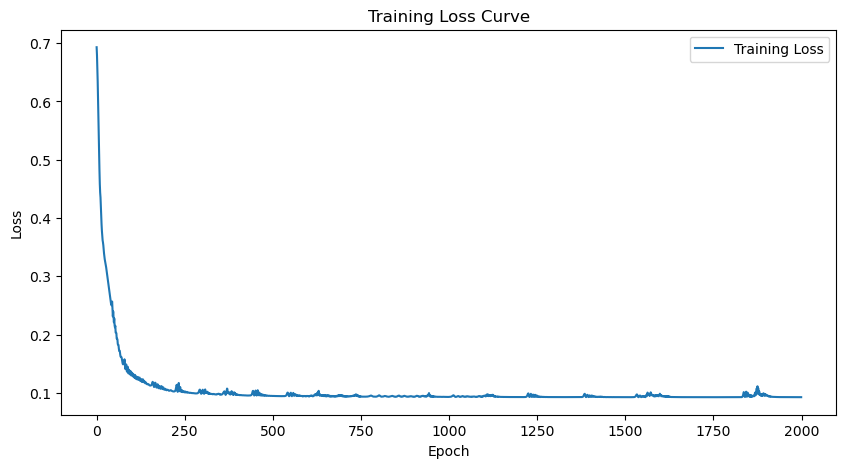

Final Model Accuracy: 77.89%
Final Model F1-score: 0.7742


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256 
print(f"Training MLP model with input_dim={input_dim} and hidden_dim={hidden_dim}")

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_0_layer.pth'.


In [11]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 77.89%
                  precision    recall  f1-score   support

    infringement       0.78      0.78      0.78       194
non_infringement       0.77      0.77      0.77       186

        accuracy                           0.78       380
       macro avg       0.78      0.78      0.78       380
    weighted avg       0.78      0.78      0.78       380



/tmp/ipykernel_1736239/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
